### Problem statement
Create a machine learning model to forecast the fuel prices for the service stations in the Rhein-Neckar district based on 
the tanker König dataset.
#### Dataset
The dataset is published on the public website “Tankerkönig“ (http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided. 

We use the stations and prices data within this website only for blog posting and demonstration
purpose. For non-commercial use the data is availble with the following license agreement (https://creativecommons.org/licenses/by-nc-sa/4.0/)

### <ins> Part 2 Model Training </ins>

#### Import the requied python packages

In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np
import geopandas

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

#### Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [6]:
!ls datasets

FuelPricesForecast_DataPreparation.ipynb
OD_AX_Gebiet_Kreis
sqldbctrace-11157.prt
stations.csv
test_groundtruth.csv
test_rnk.csv
train_rnk.csv


#### Load csv files provided by part 1 of the notebook

In [7]:
# retrive hana dataframes from CSV files
test_groundtruth_rnk_pd = pd.read_csv('./datasets/test_groundtruth.csv', sep=',', header=None, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"],)
# create hana dataframe from stadions pandas dataframe
test_gt_rnk_hdf = create_dataframe_from_pandas(
        conn,
        test_groundtruth_rnk_pd,
        schema='DEMO_GASSTATION_DATA',
        table_name="TEST_GT_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station_uuid": "NVARCHAR(50)", "e5": "DOUBLE"}  
    )

100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


In [9]:
# retrive hana dataframes from CSV files
test_rnk_pd = pd.read_csv('./datasets/test_rnk.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"])
# create hana dataframe from stadions pandas dataframe
test_rnk_hdf = create_dataframe_from_pandas(
        conn,
        test_rnk_pd,
        schema='DEMO_GASSTATION_DATA',
        table_name="TEST_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station_uuid": "NVARCHAR(50)", "e5": "DOUBLE"}  
    )

100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


In [10]:
# retrive hana dataframes from CSV files
train_rnk_pd = pd.read_csv('./datasets/train_rnk.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"])
# create hana dataframe from stadions pandas dataframe
train_rnk_hdf = create_dataframe_from_pandas(
        conn,
        train_rnk_pd,
        schema='DEMO_GASSTATION_DATA',
        "TRAIN_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station": "NVARCHAR(50)", "e5": "DOUBLE"}
    )

100%|██████████| 8/8 [01:22<00:00, 10.26s/it]


## Time series forecasting using Prophet (Additive Model Forecast)
Massive Mode Support available for ARIMA, Auto ARIMA, Additive Model Forecast, UnifiedClassification, UnifiedRegression.

In [11]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

In [12]:
conn.sql_tracer.enable_sql_trace(True)
conn.sql_tracer.enable_trace_history(True)

In [16]:
# create hoildays table, required but kept empty for now
holiday_data_hdf = conn.sql('select * from "DEMO_GASSTATION_DATA"."PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY"')

In [17]:
amf = AdditiveModelForecast(massive=True,growth='linear',
                                changepoint_prior_scale=0.06,
                                weekly_seasonality='True',
                                daily_seasonality='True'
                                )

In [18]:
amf.fit(data=train_rnk_hdf, key="date", group_key="station_uuid", holiday=holiday_data_hdf)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[1] := N'GROWTH';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'linear';
group_id[2] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[2] := N'WEEKLY_SEASONALITY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
group_id[3] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[3] := N'DAILY_SEASONALITY';
int_value[3] := 1;
double_value[3] := NULL;
string_value[3] := NULL;
group_id[4] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[4] := N'CHANGEPOINT_PRIOR_SCALE';
int_value[4] := NULL;
double_value[4] := 0.06;
string_value[4] := NULL;
params = UNNEST(:group_id, :param_name, :int_value, :double_value, :string_value);
in_0 = SE

In [19]:
print(conn.last_execute_statement)

DO
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[1] := N'GROWTH';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'linear';
group_id[2] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[2] := N'WEEKLY_SEASONALITY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
group_id[3] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[3] := N'DAILY_SEASONALITY';
int_value[3] := 1;
double_value[3] := NULL;
string_value[3] := NULL;
group_id[4] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[4] := N'CHANGEPOINT_PRIOR_SCALE';
int_value[4] := NULL;
double_value[4] := 0.06;
string_value[4] := NULL;
params = UNNEST(:group_id, :param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "station_uuid", "date", "e5" FR

In [20]:
amf.model_.head(5).collect()

,GROUP_ID,ROW_INDEX,MODEL_CONTENT
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
1,0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
3,11751341-2a8d-4408-af81-a4a01e054314,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."
4,10d13975-7819-4c49-86be-3465bfdc59f9,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MO..."


In [21]:
result = amf.predict(data=test_rnk_hdf, key="date", group_key="station_uuid")

INFO:hana_ml.ml_base:Executing SQL: DO (IN in_1 TABLE ("GROUP_ID" NVARCHAR(100), "ROW_INDEX" INT, "MODEL_CONTENT" NCLOB) => "#PAL_MASSIVE_ADDITIVE_MODEL_FORECAST_MODEL_TBL_1_CE216074_3436_11ED_BC1D_ACDE48001122")
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
group_id[1] := N'1';
param_name[1] := N'PLACE_HOLDER';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'place_holder';
params = UNNEST(:group_id, :param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "station_uuid", "date", "e5" FROM (SELECT "date", "station_uuid", "e5" FROM (SELECT * FROM "DEMO_GASSTATION_DATA"."TEST_RNK") dt) AS "DT_5";
CALL _SYS_AFL.PAL_MASSIVE_ADDITIVE_MODEL_PREDICT(:in_0, :in_1, :params, out_0, out_1, out_2);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_ADDITIVE_MODEL_PREDICT_FORECAST_RESULT_TBL_1_FE4A4432_3436_11ED_BC1D_ACDE48001122

In [22]:
# look at predictions for one service stations
# predict returns an array of three dataframes. The first contains the porcted values

result[0].head(10).collect()

,GROUP_ID,date,YHAT,YHAT_LOWER,YHAT_UPPER
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:04:12,2.012191,1.957376,2.068663
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:14:10,2.030731,1.973301,2.084730
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 07:52:09,1.973850,1.919704,2.029074
3,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 08:12:09,1.955445,1.897891,2.010219
4,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 09:16:09,1.923153,1.871691,1.978814
5,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 10:32:09,1.921132,1.865894,1.978608
6,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 10:52:08,1.921533,1.862229,1.979625
7,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 12:16:09,1.914496,1.860899,1.969912
8,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 13:32:09,1.909315,1.847870,1.965197
9,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 13:52:10,1.910335,1.856274,1.962363


In [23]:
# load the results into a pandas dataframe for plotting
result_pd = result[0].collect()

### Plot predicted fuel prices for a couple of service station

In [25]:
# load gas station data from csv
stations_pd = pd.read_csv('./datasets/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

In [26]:
# 938c082c-e2c6-4292-8b2c-cdf83036e555 AVIA
# 9706790d-b179-426b-99ea-2d7346241ca9 Oili
station1 = stations_pd[stations_pd['uuid']=="018e8f3e-ae2f-40bc-89c1-bc3fe20eb462"] #Mülhausen
station2 = stations_pd[stations_pd['uuid']=="938c082c-e2c6-4292-8b2c-cdf83036e555"] #Walldorf AVIA
station3 = stations_pd[stations_pd['uuid']=="9706790d-b179-426b-99ea-2d7346241ca9"] #Walldorf Oili

In [27]:
# 
to_plot2_pd = train_rnk_hdf.filter('"station_uuid" =\'938c082c-e2c6-4292-8b2c-cdf83036e555\'').collect()
to_plot3_pd = train_rnk_hdf.filter('"station_uuid" =\'9706790d-b179-426b-99ea-2d7346241ca9\'').collect()

In [29]:
to_plot2_gt_pd = test_gt_rnk_hdf.filter('"station_uuid" =\'938c082c-e2c6-4292-8b2c-cdf83036e555\'').sort('date').collect()
to_plot3_gt_pd = test_gt_rnk_hdf.filter('"station_uuid" =\'9706790d-b179-426b-99ea-2d7346241ca9\'').sort('date').collect()

In [30]:
to_plot2_pred_pd = result_pd[result_pd['GROUP_ID']=="938c082c-e2c6-4292-8b2c-cdf83036e555"]
to_plot3_pred_pd = result_pd[result_pd['GROUP_ID']=="9706790d-b179-426b-99ea-2d7346241ca9"]

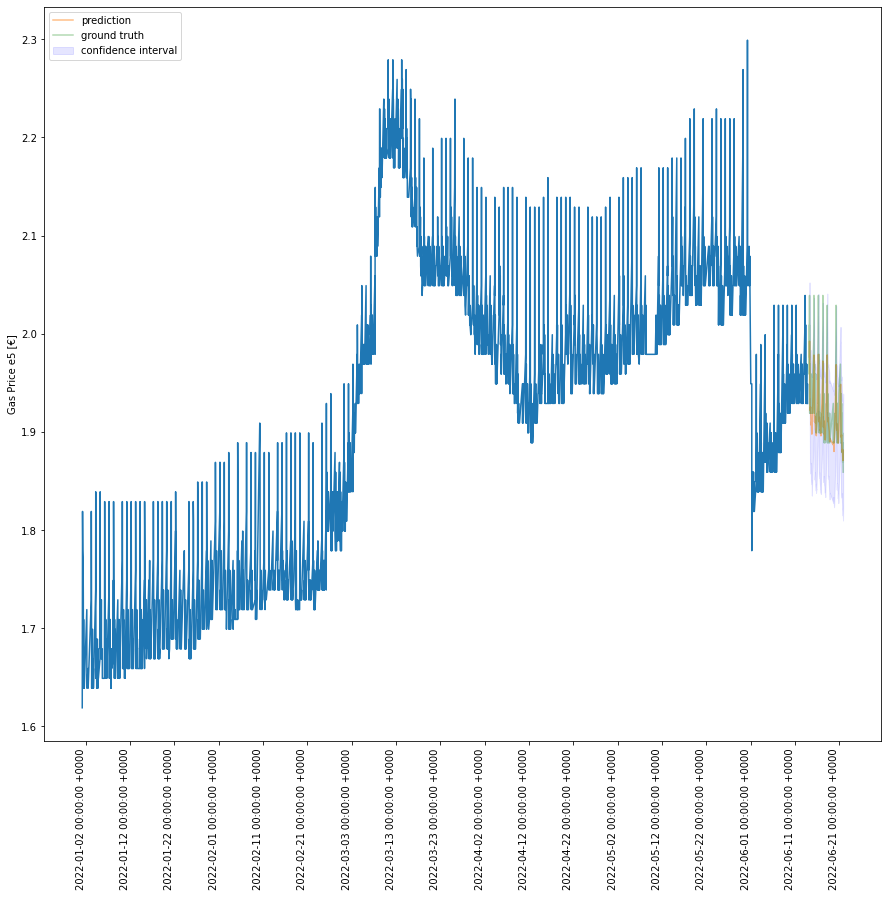

In [31]:
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
figure(figsize=(15, 15))

to_plot2_pd = to_plot2_pd.sort_values('date', ascending=True)
to_plot2_pd['date'] = pd.to_datetime(to_plot2_pd['date'],  utc=True)

#to_plot3_pd = to_plot3_pd.sort_values('date', ascending=True)
#to_plot3_pd['date'] = pd.to_datetime(to_plot3_pd['date'],  utc=True)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S %z'))  #'%Y-%m-%d %H:%M:%S.%f %z %Z'
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.gcf().autofmt_xdate(rotation=90)


#plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'], label='AVIA' )
plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'])
plt.plot(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT'], label='prediction', alpha=.5 )
plt.plot(to_plot2_gt_pd['date'], to_plot2_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
plt.fill_between(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT_LOWER'], to_plot2_pred_pd['YHAT_UPPER'], color='b', alpha=.1, label= 'confidence interval')
plt.legend(loc="upper left")
plt.ylabel('Gas Price e5 [€]')
plt.show()

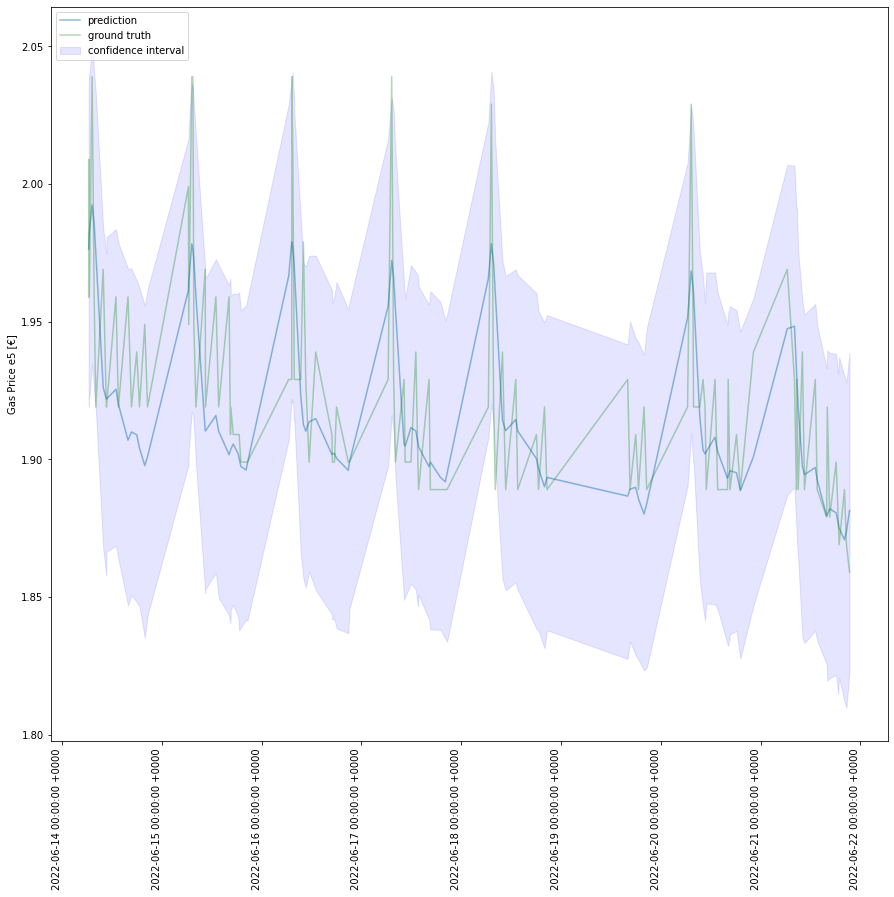

In [32]:
# let's look at the predicted values only
figure(figsize=(15, 15))

to_plot2_pd = to_plot2_pd.sort_values('date', ascending=True)
to_plot2_pd['date'] = pd.to_datetime(to_plot2_pd['date'],  utc=True)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S %z'))  #'%Y-%m-%d %H:%M:%S.%f %z %Z'
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.gcf().autofmt_xdate(rotation=90)


#plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'], label='AVIA' )
#plt.plot(to_plot3_pd['date'], to_plot3_pd['e5'])
plt.plot(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT'], label='prediction', alpha=.5 )
plt.plot(to_plot2_gt_pd['date'], to_plot2_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
plt.fill_between(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT_LOWER'], to_plot2_pred_pd['YHAT_UPPER'], color='b', alpha=.1, label= 'confidence interval')
plt.legend(loc="upper left")
plt.ylabel('Gas Price e5 [€]')
plt.show()

In [33]:
from hana_ml.artifacts.generators import hana

In [34]:
hg = hana.HanaGenerator(project_name="AdditiveModel", version='1', grant_service='',
                        connection_context=conn, outputdir="./hana_hdi")

In [35]:
hg.generate_artifacts()

'./hana_hdi/AdditiveModel/hana'

In [38]:
!ls hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/

base_additivemodelforecast1_fit.hdbprocedure
base_additivemodelforecast2_fit.hdbprocedure
base_additivemodelforecast2_predict.hdbprocedure
cons_base_additivemodelforecast1_fit.hdbprocedure
cons_base_additivemodelforecast2_fit.hdbprocedure
cons_base_additivemodelforecast2_predict.hdbprocedure


In [42]:
!cat hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/base_additivemodelforecast2_fit.hdbprocedure

PROCEDURE base_additivemodelforecast2_fit(in lt_in_0_additivemodelforecast2_fit table ("station_uuid" NVARCHAR(5000),"date" TIMESTAMP,"e5" DOUBLE), in lt_model_in_1_additivemodelforecast2_fit table ("GROUP_IDXXX" INT,"ts" TIMESTAMP,"NAME" NVARCHAR(255),"LOWER_WINDOW" INT,"UPPER_WINDOW" INT), out lt_model_out_0_additivemodelforecast2_fit table ("GROUP_ID" NVARCHAR(100),"ROW_INDEX" INT,"MODEL_CONTENT" NCLOB), out lt_model_out_1_additivemodelforecast2_fit table ("GROUP_ID" NVARCHAR(100),"ERROR_TIMESTAMP" NVARCHAR(100),"ERRORCODE" INT,"MESSAGE" NVARCHAR(200)))
    LANGUAGE SQLSCRIPT
    SQL SECURITY INVOKER
    AS
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
in_1 = SELECT * FROM :lt_model_in_1_additivemodelforecast2_fit;
in_0 = SELECT * FROM :lt_in_0_additivemodelforecast2_fit;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_n

In [44]:
!cat hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/base_additivemodelforecast2_predict.hdbprocedure

PROCEDURE base_additivemodelforecast2_predict(in lt_in_0_additivemodelforecast2_predict table ("station_uuid" NVARCHAR(50),"date" TIMESTAMP,"e5" DOUBLE), in lt_model_in_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"ROW_INDEX" INT,"MODEL_CONTENT" NCLOB), out lt_model_out_0_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"YHAT" DOUBLE,"YHAT_LOWER" DOUBLE,"YHAT_UPPER" DOUBLE), out lt_model_out_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"TREND" DOUBLE,"SEASONAL" NCLOB,"HOLIDAY" NCLOB,"EXOGENOUS" NCLOB), out lt_model_out_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"TREND" DOUBLE,"SEASONAL" NCLOB,"HOLIDAY" NCLOB,"EXOGENOUS" NCLOB), out lt_model_out_2_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"ERROR_TIMESTAMP" NVARCHAR(100),"ERRORCODE" INT,"MESSAGE" NVARCHAR(200)), out lt_model_out_2_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100)